# 1. Chargement des librairies nécessaires

In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import statsmodels.api as sm
from statsmodels.formula.api import ols
import scipy.stats as stat
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split,learning_curve,cross_val_score,RandomizedSearchCV,GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score,roc_curve,auc,classification_report,accuracy_score,confusion_matrix,f1_score

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression 
from xgboost import XGBClassifier
from sklearn import tree
from sklearn.tree import export_graphviz
import graphviz

# 2. Importation et préparation des données

In [ ]:
data=pd.read_excel('new_base2_final.xlsx')
data.isna().sum()

In [ ]:
# Rename columns names
data=data.rename(columns={"marche_contractante": "M_ctractante", "segment_distributif_contractante": "S_D_Ctractante",
"marche_payeuse": "M_pay","segment_distributif_payeuse": "S_D_pay","segment_marketing_payeuse": "S_M_pay",
    "version_utilisation": "V_Utili", "car_qad_mwh": "C_q_mwh", "region": "Reg", "tranche_effectif": "Tr_effectif",
    "categorieEntreprise": "CateEntreprise", "NAF_contractante": "NAF_ctractante", "CLUST6":"classes",
        "puissance": "Puissance"})
data.columns

In [ ]:
# Imputation

## Quantitative variable
med1=float(data['Puissance'].median())
med2=float(data['nb_siret'].median())
data['Puissance'] =  data['Puissance'].fillna(med1)
data['nb_siret'] =  data['nb_siret'].fillna(med2)

## Qualitative variable
### convert object to categorical
for col in data.columns:
    if data.dtypes[col]=="object":
        data[col]=data[col].astype("category")

for col in data.columns:
    if data.dtypes[col]=="category":
        data[col].bfill(axis='rows',inplace=True)
        
data.isna().sum()

# 3. Analyse exploratoire

## 3.1 Analyse univariée

In [ ]:
data.describe()

In [ ]:
# Statistiques descriptives par cluster
data.groupby('classes').describe()

In [ ]:
data.groupby('classes').mean()

In [ ]:
# Diagramme à bande des variables quantitatives
for col in data.columns:
    if data.dtypes[col]=="category" and col!='classes':
        plt.figure()
        ax=sns.countplot(x=col, data=data, hue='classes')

### Figure 1: Répartition des clients par cluster

In [ ]:
#Pie chart 
plt.style.use('seaborn')
print("Répartition des clusters dans la population")
plt.figure(figsize=(6*2,6))
colors_list=['gold', 'yellowgreen', 'lightcoral', 'blue','skyblue','red']
explode_list = [0.2,0.1,0.2,0.1,0.3,0.2] 
                                             # spécifie la fraction du rayon avec laquelle il faut décaler chaque continent.
data['classes'].value_counts().plot(kind='pie',   
                            autopct='%1.1f%%',   # mettre les valeurs en pourcentages 
                            startangle=90,    
                            shadow=True,       
                            labels=None,        # retirer la légende sur le graphique
                            pctdistance=1.12,    # la distance entre le camembert et les pourcentages
                            colors=colors_list,
                            explode=explode_list                        # ajouter les couleurs définies plus haut 
                            )
plt.legend(labels=['Classe 3','Classe 4','Classe 5','Classe 2','Classe 6','Classe 1'], loc='best',
           bbox_to_anchor=(0.85, 0., 0.5, 0.5)) 
plt.ylabel("")
plt.savefig("diagrcirc1")
plt.show()

## 3.2 Analyse bivariée

**Quantitative feature VS target**

In [ ]:
# Box-plots
plt.style.use('seaborn')
plt.figure(figsize=(20,15))
for i, col in enumerate(data[['Puissance','nb_siret','C_q_mwh']].columns):
    plt.subplot(2,2,i+1)
    sns.boxplot(data['classes'],data[col],showmeans=True)
plt.subplots_adjust(left=0.1,bottom=0.1,right=0.9,top=0.6,wspace=0.3,hspace=0.3)


In [ ]:
# Analysis of variance (ANOVA)
model_a=ols('C_q_mwh~classes', data=data).fit()
model_b=ols('nb_siret~classes', data=data).fit()
model_c=ols('Puissance~classes', data=data).fit()
print("Consommation VS Target \n", sm.stats.anova_lm(model_a, typ=2),"\n")
print("Nombre de siret VS Target \n", sm.stats.anova_lm(model_b, typ=2),"\n")
print("Puissance VS Target \n", sm.stats.anova_lm(model_c, typ=2))

**Toutes les p-values (PR(>F)) sont inférieures à 0.05 : les variables quantitatives ont donc un lien potentiel avec la target.**

**Qualitative feature VS target**

In [ ]:
# Chi-square test
data['classes']=data['classes'].astype("category")
for col in data.columns:
    if data.dtypes[col]=="category" and col!="classes":
        chi2_stat, p_val, dof, ex=stat.chi2_contingency(pd.crosstab(data['classes'], data[col]))
        print("Chi square test for: {} \n Chi2 Stat : {} - P-Value : {} \n".format(col, round(chi2_stat,3),p_val,3))

**Toutes les p-values (PR(>F)) sont inférieures à 0.05 : les variables qualitatives ont donc un lien potentiel avec la target.**

### Figure 2: Distribution de la consommation d’énergie par cluster

In [ ]:
sns.boxplot(data['classes'],data['C_q_mwh'],showmeans=True,
                     meanprops={"markersize":"10"})
# Lest triangles rouges représentent les moyennes par classe
plt.xlabel("Classes", size=14)
plt.ylabel("Consommation en KWh", size=14)
plt.title("Consommation d'énergie par classes", size=18)
plt.savefig("box_plot_means.png")
plt.show()

# 4. Modélisation

In [ ]:
# Categoricals features Encoding
OHE_data=pd.get_dummies(data, columns=['M_ctractante', 'S_D_Ctractante', 'M_pay','S_D_pay','S_M_pay',
                    'V_Utili','Reg','CateEntreprise','Tr_effectif','NAF_ctractante','NAF_payeuse'])
print(OHE_data.shape)
OHE_data.head()

In [68]:
# data Scaling and splitting

eX=OHE_data.drop(['classes','id'], axis=1)
scaler = MinMaxScaler()
X = scaler.fit_transform(eX)

y=OHE_data['classes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [70]:
#function to build ROC curve
def roc_auc(model):
    clr=model.fit(X_train,y_train)
    probas = clr.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, probas[:, 1], pos_label=clr.classes_[1], drop_intermediate=False)
    fig, ax = plt.subplots(1, 1, figsize=(6,6))
    ax.plot([0, 1], [0, 1], 'k--',color='red')
    aucf = auc(fpr, tpr)  # seconde façon
    ax.plot(fpr, tpr, label='succes' ,color='blue')
    ax.text(0.35, 0.6, f"AUC ={round(aucf,2)}",color='blue')
    ax.set_title(f'Courbe ROC')
    ax.set_xlabel("FPR")
    ax.set_ylabel("TPR")
    
    return 

In [106]:
#function to train and evaluate models
def evaluation(model):
   # X_train échantillon d'apprentissage et x_test échantillon test
    model.fit(X_train,y_train)
    y_predict=model.predict(X_test)
       
    # Scores moyens
    score_moy=cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()
    print("Le score moyen est : {} \n ".format(round(score_moy*100,3)))
        
    #Computing False Positives(FP), False Negatives(FN), True Positive(TP) and True Negative(TN)
    cm=confusion_matrix(y_test,y_predict)
    FP,FN=cm.sum(axis=0) - np.diag(cm),cm.sum(axis=1) - np.diag(cm)
    TP=np.diag(cm)
    TN=cm.sum() - (FP+FN+TP)
    # Métrique de performance
    Sensi,Speci,Preci,NPV,CE,ACC=TP/(FN+TP),TN/(TN+FP),TP/(TP+FP),TN/(TN+FN),(FP+FN)/(TN+TP+TN+FN),(TP+TN)/(TN+TP+TN+FN)
   
    #Average metrics
    print("The average sensitivity is: {} % \n ".format(round(((Sensi.sum()/6)*100),3)))
    print("The average specificity is: {} % \n ".format(round(((Speci.sum()/6)*100),3)))
    print("The average classification error is: {} % \n ".format(round(((CE.sum()/6)*100),3)))
    print("The average accuracy is: {} % \n ".format(round(((ACC.sum()/6)*100),3)))
    
    print("Rapport de la classification \n",classification_report(y_test,y_predict))

    
    mat_conf=sns.heatmap(cm, annot=True)
    plt.title("Matrice de confusion")
    plt.xlabel('Classes Prédictes')
    plt.ylabel('Classes réelles')
    plt.show()
    print(mat_conf)
    
    
    train_sizes_abs, train_scores, test_scores = learning_curve(model,
            X_train, y_train, cv=10, n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50))
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)

    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    plt.subplots(1, figsize=(10,10))
    plt.style.use('seaborn')
    plt.plot(train_sizes_abs, train_mean, '--', color="#111111",  label="Training score")
    plt.plot(train_sizes_abs, test_mean, color="#111111", label="Cross-validation score")

    plt.fill_between(train_sizes_abs, train_mean - train_std, train_mean + train_std, color="#DDDDDD")
    plt.fill_between(train_sizes_abs, test_mean - test_std, test_mean + test_std, color="#DDDDDD")

    plt.title("Learning Curve")
    plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")
    #plt.tight_layout()
    plt.show()
    roc_auc(model)
        
    plt.show()

## 4.1 Decision tree

**Optimal hyperparameters Research**

In [ ]:
# Choix de quelques hyper-paramètres clefs
# on crée un dictionnaire contenant le nom du model et hyper-paramètres clefs
dt_params = {
        'Decision_Tree': {
        'model': DecisionTreeClassifier(),
        'params' : {
            'max_depth': np.arange(1,10,2),
            'min_samples_split': np.arange(1,10,2),
            'min_samples_leaf': np.arange(1,10,2),
            'max_features': np.arange(1,90,1)
        }
    }
}

scores = [] # une liste vide qui va récupérer les scores pour différentes combinaisons d'hyper_paramètres

for model_name, mp in dt_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], cv=5,n_jobs=-1, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
# Affichage des valeurs optimales des hypers-paramètres
scores

Le score moyen est : 59.363 
 
The average sensitivity is: 45.703 % 
 
The average specificity is: 91.284 % 
 
The average classification error is: 7.855 % 
 
The average accuracy is: 51.738 % 
 
Rapport de la classification 
               precision    recall  f1-score   support

           1       0.45      0.37      0.40        49
           2       0.24      0.31      0.27        81
           3       0.80      0.86      0.83       406
           4       0.35      0.25      0.29       102
           5       0.57      0.50      0.53       103
           6       0.50      0.45      0.47        69

    accuracy                           0.62       810
   macro avg       0.48      0.46      0.47       810
weighted avg       0.61      0.62      0.61       810



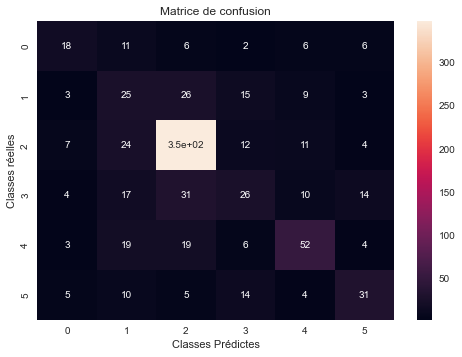

AxesSubplot(0.125,0.125;0.62x0.755)


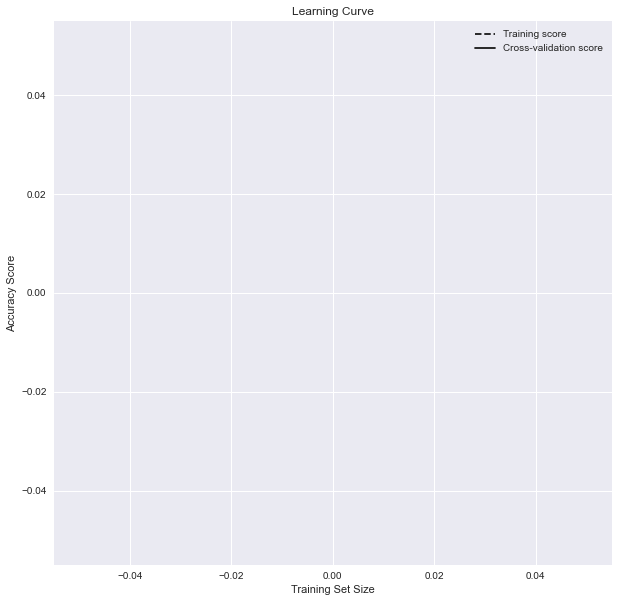

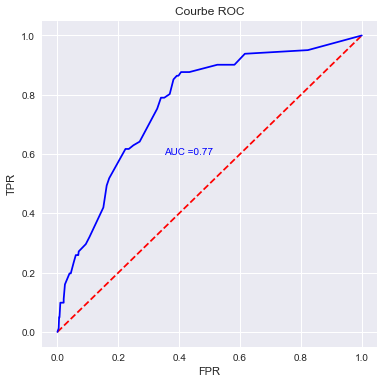

In [90]:
#Estimation et évaluation du modèle avec les valeurs optimales des hypers-paramètres retenues
evaluation(DecisionTreeClassifier(max_depth =9, max_features = 40, min_samples_leaf = 7, min_samples_split = 7))

### Figure 3 : Aperçu de l’arbre de décision

In [ ]:
import graphviz

dt=DecisionTreeClassifier(max_depth =9, max_features = 40, min_samples_leaf = 7,
   min_samples_split = 7)
dt.fit(X_train, y_train)

dot_file = export_graphviz(dt, feature_names=eX.columns)
graph = graphviz.Source(dot_file)
graph.render('tree', format='png')

## 4.2 Logistic Regression

**Optimal hyperparameters Research**

In [ ]:
lr_params = {
        'logistic_regression' : {
        'model': LogisticRegression(solver='lbfgs',multi_class='multinomial'),
        'params': {
            'C': np.arange(1,20,1)
        }
    }
}

scores = []

for model_name, mp in lr_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], cv=5, n_jobs=-1, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })

# Affichage des valeurs optimales des hypers-paramètres
scores

Le score moyen est : 62.392 
 
The average sensitivity is: 46.069 % 
 
The average specificity is: 91.103 % 
 
The average classification error is: 7.618 % 
 
The average accuracy is: 52.133 % 
 
Rapport de la classification 
               precision    recall  f1-score   support

           1       0.41      0.45      0.43        49
           2       0.34      0.20      0.25        81
           3       0.76      0.90      0.83       406
           4       0.41      0.25      0.31       102
           5       0.53      0.47      0.50       103
           6       0.46      0.49      0.48        69

    accuracy                           0.63       810
   macro avg       0.48      0.46      0.47       810
weighted avg       0.60      0.63      0.61       810



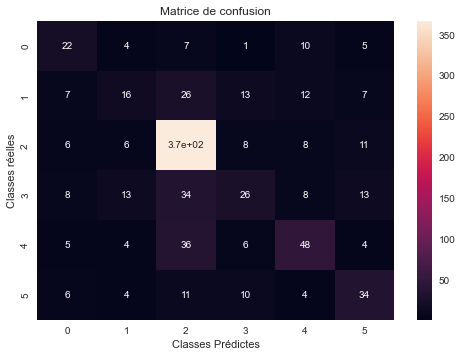

AxesSubplot(0.125,0.125;0.62x0.755)


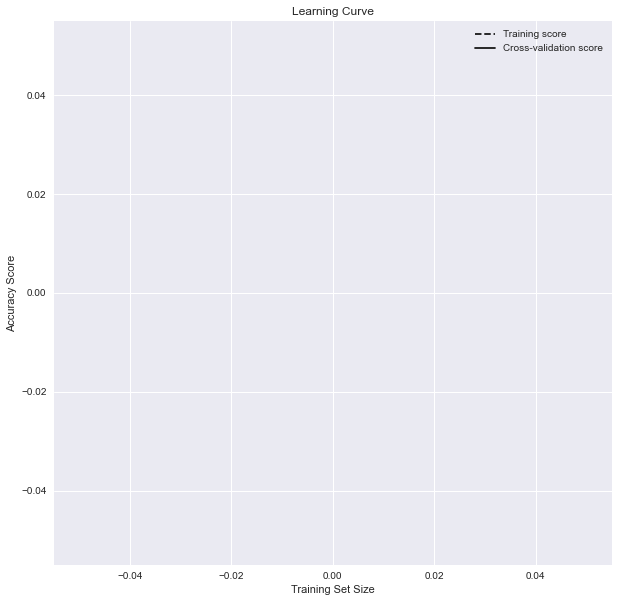

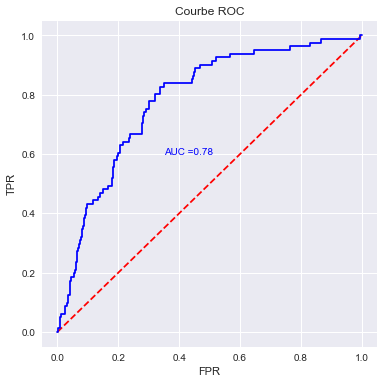

In [89]:
#Estimation et évaluation du modèle avec les valeurs optimales des hypers-paramètres retenues
evaluation(LogisticRegression(solver='lbfgs',multi_class='multinomial', C=9))

## 4.3 SVM

**Optimal hyperparameters Research**

In [83]:
svm_params = {
        'svm': {
        'model': svm.SVC(gamma='auto'),
        'params' : {
            'C': [int(x) for x in np.linspace(start = 10, stop = 110, num = 11)],
            'kernel': ['rbf','linear']
        }  
    }
}

scores = []

for model_name, mp in svm_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], cv=5, n_jobs=-1, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })

# Affichage des valeurs optimales des hypers-paramètres
scores

[{'model': 'svm',
  'best_score': 0.6350468448871334,
  'best_params': {'C': 90, 'kernel': 'rbf'}}]

Le score moyen est : 60.383 
 
The average sensitivity is: 47.017 % 
 
The average specificity is: 91.251 % 
 
The average classification error is: 7.721 % 
 
The average accuracy is: 51.884 % 
 
Rapport de la classification 
               precision    recall  f1-score   support

           1       0.38      0.43      0.40        49
           2       0.33      0.28      0.30        81
           3       0.78      0.86      0.82       406
           4       0.44      0.34      0.39       102
           5       0.51      0.49      0.50       103
           6       0.48      0.42      0.45        69

    accuracy                           0.63       810
   macro avg       0.49      0.47      0.48       810
weighted avg       0.61      0.63      0.62       810



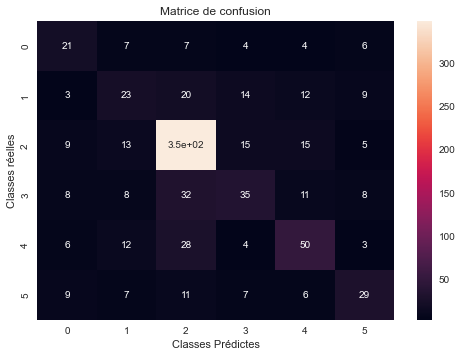

AxesSubplot(0.125,0.125;0.62x0.755)


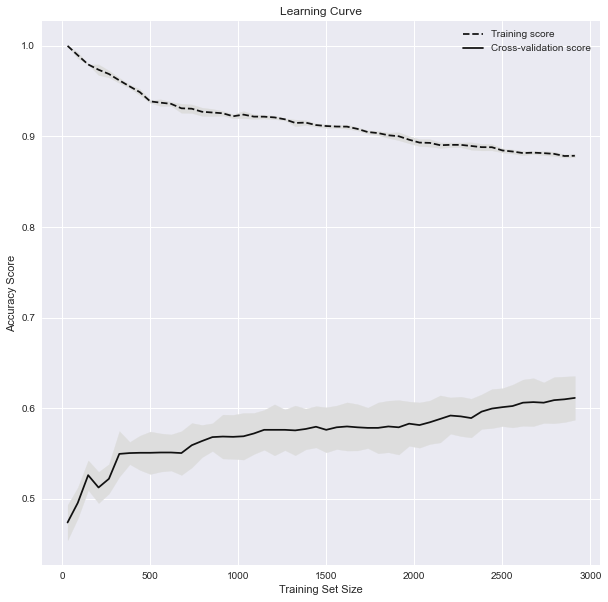

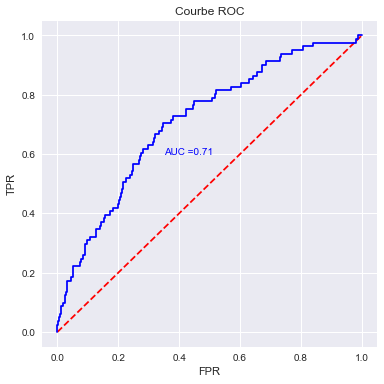

In [109]:
#Estimation et évaluation du modèle avec les valeurs optimales des hypers-paramètres retenues
evaluation(SVC(kernel = 'rbf', C = 90,probability=True))

## 4.4 Random Forest

**Optimal hyperparameters Research**

In [86]:
rf_params = {
        'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'n_estimators': [int(x) for x in np.linspace(start = 10, stop = 110, num = 11)],
            'max_depth': [int(x) for x in np.linspace(4, 20, num = 3)],
            'bootstrap': [True, False]
        }  
    }
}

scores = []

for model_name, mp in rf_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], cv=5, n_jobs=-1, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })

# Affichage des valeurs optimales des hypers-paramètres
scores

[{'model': 'random_forest',
  'best_score': 0.6350497071001966,
  'best_params': {'bootstrap': True, 'max_depth': 12, 'n_estimators': 30}}]

Le score moyen est : 63.103 
 
The average sensitivity is: 46.924 % 
 
The average specificity is: 90.945 % 
 
The average classification error is: 7.65 % 
 
The average accuracy is: 52.277 % 
 
Rapport de la classification 
               precision    recall  f1-score   support

           1       0.46      0.51      0.49        49
           2       0.26      0.15      0.19        81
           3       0.74      0.90      0.81       406
           4       0.45      0.29      0.36       102
           5       0.64      0.52      0.57       103
           6       0.48      0.43      0.46        69

    accuracy                           0.64       810
   macro avg       0.51      0.47      0.48       810
weighted avg       0.60      0.64      0.61       810



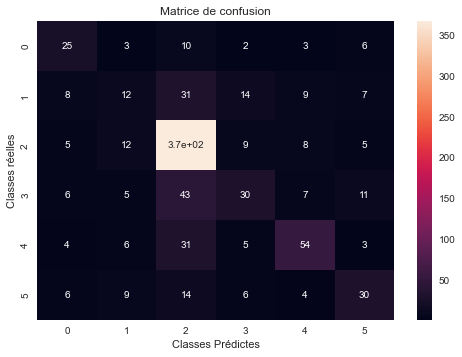

AxesSubplot(0.125,0.125;0.62x0.755)


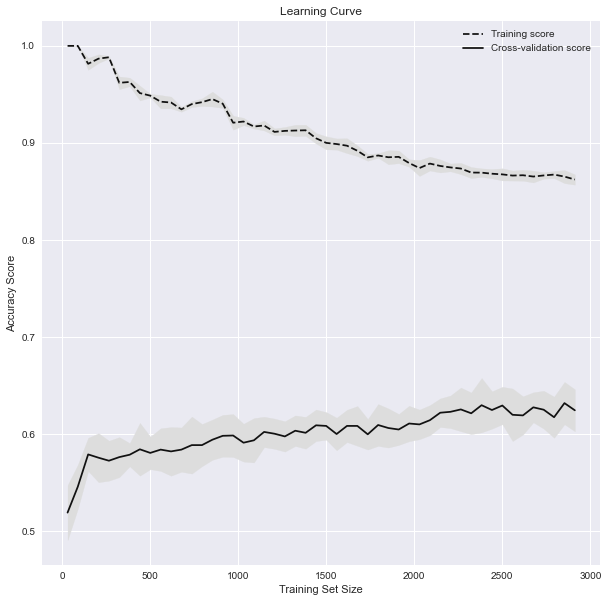

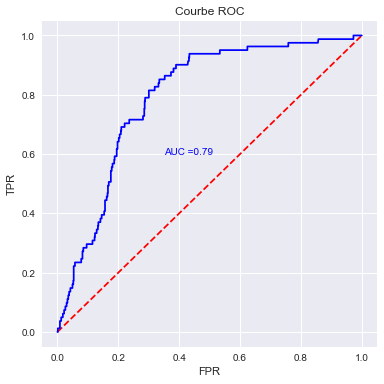

In [108]:
#Estimation et évaluation du modèle avec les valeurs optimales des hypers-paramètres retenues
evaluation(RandomForestClassifier(n_estimators = 30, max_depth=12,bootstrap=True, random_state = 42))

## 4.5 Extreme Gradient Boosting (XGBoost)

**Optimal hyperparameters Research**

<h3 align='right' style='color:red'>NB : La méthode de la Grid Search prendra au moins 1h selon la performance de votre PC.</h3>

In [ ]:
xgb_params = {
        'XGB_Classifier': {
        'model': XGBClassifier(objective='multi:softprob', random_state=0, n_jobs=-1),
        'params' : {
            'learning_rate': [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
            'max_depth' : [int(x) for x in np.linspace(4, 20, num = 3)],
            'min_child_weight' : [ 1, 3, 5, 7 ],
            'gamma' : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
            'colsample_bytree' : [ 0.3, 0.4, 0.5 , 0.7 ]
        }  
    }
}

scores = []

for model_name, mp in xgb_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], cv=5, n_jobs=-1, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })

# Affichage des valeurs optimales des hypers-paramètres
scores

<h3 align='right' style='color:red'>Nous avons donc utilisé la méthode de la Randomized Search pour une meilleure durée de traitement.</h3>

In [ ]:
params = {
            'learning_rate': [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
            'max_depth' : [int(x) for x in np.linspace(4, 20, num = 3)],
            'min_child_weight' : [ 1, 3, 5, 7 ],
            'gamma' : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
            'colsample_bytree' : [ 0.3, 0.4, 0.5 , 0.7 ]    
}

xgb=XGBClassifier(objective='multi:softprob', random_state=0, n_jobs=-1)

xgb_random=RandomizedSearchCV(estimator = xgb,param_distributions=params,n_iter = 100,
                                 random_state=42,n_jobs=-1,cv=3,verbose=2)
hyper_search = xgb_random.fit(X_train, y_train)

# Affichage des valeurs optimales des hypers-paramètres
hyper_search.best_params_

Le score moyen est : 63.999 
 
The average sensitivity is: 50.705 % 
 
The average specificity is: 91.702 % 
 
The average classification error is: 7.09 % 
 
The average accuracy is: 52.295 % 
 
Rapport de la classification 
               precision    recall  f1-score   support

           1       0.49      0.55      0.52        49
           2       0.35      0.22      0.27        81
           3       0.77      0.89      0.83       406
           4       0.46      0.36      0.40       102
           5       0.62      0.53      0.57       103
           6       0.51      0.48      0.49        69

    accuracy                           0.66       810
   macro avg       0.53      0.51      0.52       810
weighted avg       0.63      0.66      0.64       810



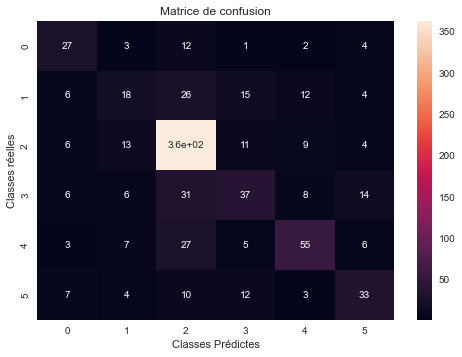

AxesSubplot(0.125,0.125;0.62x0.755)


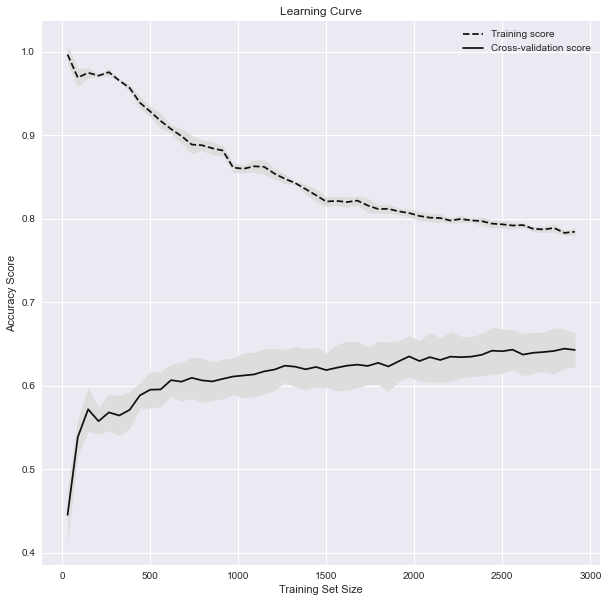

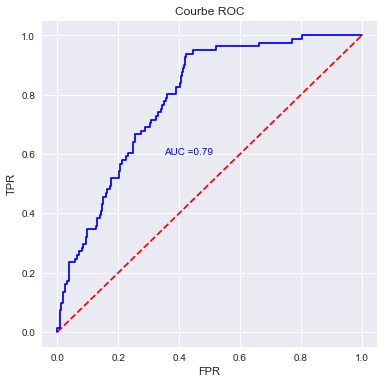

In [107]:
#Estimation et évaluation du modèle avec les valeurs optimales des hypers-paramètres retenues
evaluation(XGBClassifier(max_depth=4,learning_rate= 0.15,min_child_weight=1,
                             gamma=0.4,colsample_bytree=0.5,verbosity=0))